In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])



In [2]:
G = 6.67e-11
M0 = 2e30
c = 3e8

def chirp_rate(f,Mc):
    return 96/5*np.pi*(np.pi*G*Mc/c**3)**(5/3)*f**(11/3)



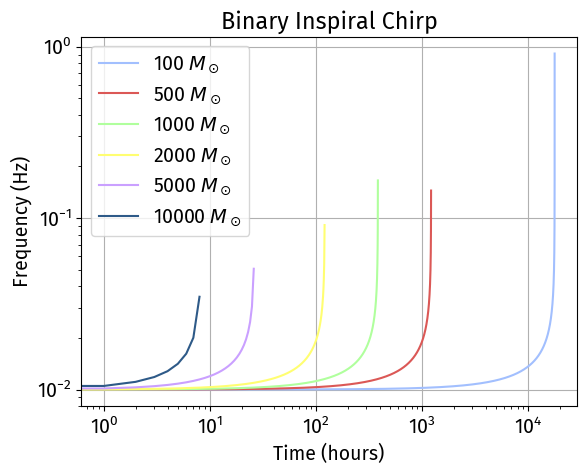

In [6]:
def chirp_constant(Mc):
    return (96/5) * np.pi**(8/3) * (G * Mc / c**3)**(5/3)

def f_t(t, f0, Mc):
    k = chirp_constant(Mc)
    return (f0**(-8/3) - (8/3) * k * t)**(-3/8)


masses = [100,500,1000,2000,5000,10000]
# Parameters

for M in masses:
    Mc = M * M0  # chirp mass in kg (example: 30 solar masses)
    f0 = 1/100         # starting frequency in Hz
    t_end = 3600*100000       # seconds until merger
    t = np.linspace(0, t_end, 100000)

    # Compute frequency evolution
    f = f_t(t, f0, Mc)

    # Plot
    plt.plot(t/3600, f, label = "%d $M_\odot$"%M)
    plt.xlabel("Time (hours)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Binary Inspiral Chirp")
    # plt.ylim([1/640,1/10])
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    
plt.legend()